In [1]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math

from OnlineHD import onlinehd

In [2]:
def load():
    # fetches data
    x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
    x = x.astype(np.float)
    y = y.astype(np.int)
    y = np.array(y)

    # split and normalize
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x, x_test, y, y_test

In [3]:
# simple OnlineHD training

print('Loading...')
x, x_test, y, y_test = load()
classes = y.unique().size(0)
features = x.size(1)

Loading...


In [4]:
model = onlinehd.OnlineHD(classes, features, dim=10000)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
model = model.fit(x, y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...


In [5]:
import pickle

with open("model+gen.pickle","wb") as fw:
    pickle.dump(model, fw)

with open("model+gen.pickle","rb") as fr:
    model2 = pickle.load(fr)

In [6]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.847295
acc_test = 0.851314
t = 1070.681365


In [31]:
generated_data = model.generate(20, "8")

In [ ]:
import matplotlib.pyplot as plt

def draw_mnist(data, axs=None):
    if axs == None:
        plt.imshow(data.reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.show()
    else:
        axs.imshow(data.reshape(28, 28), cmap=plt.get_cmap('gray'))
        axs.axis('off')


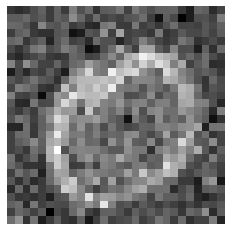

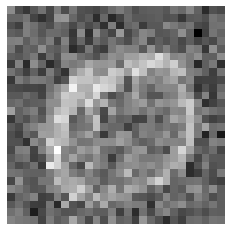

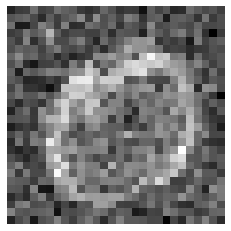

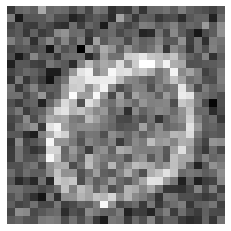

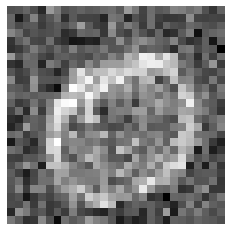

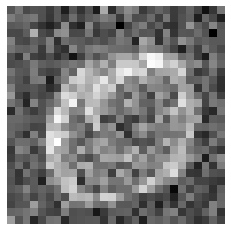

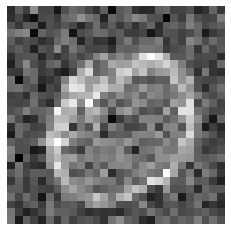

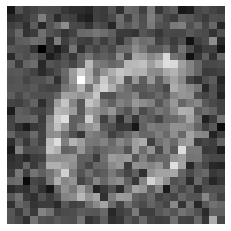

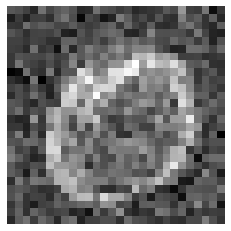

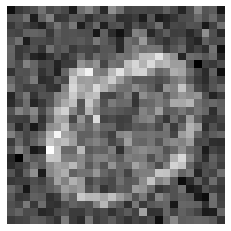

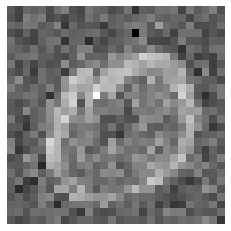

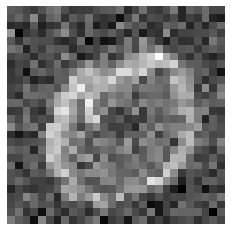

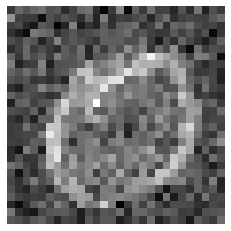

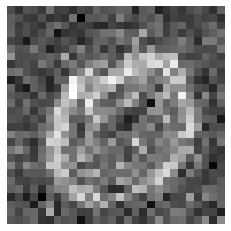

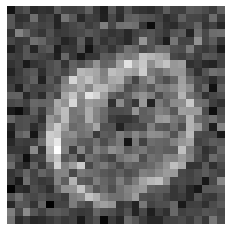

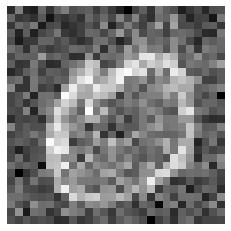

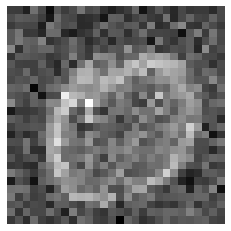

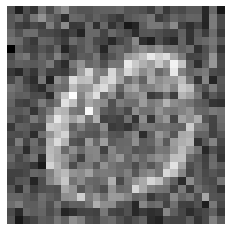

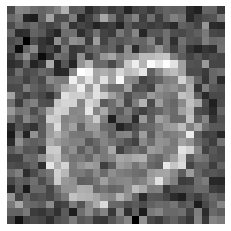

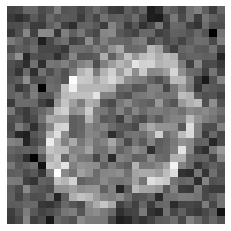

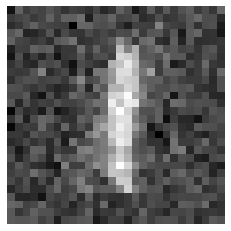

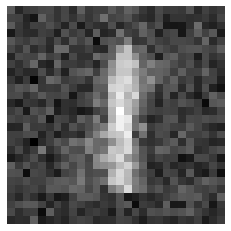

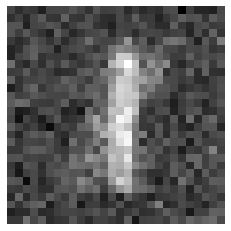

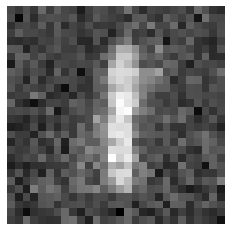

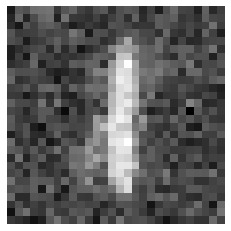

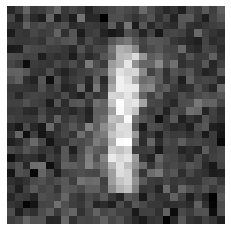

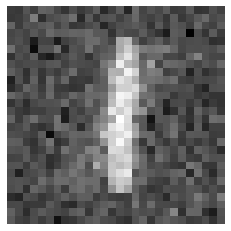

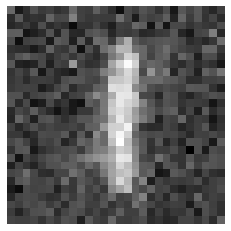

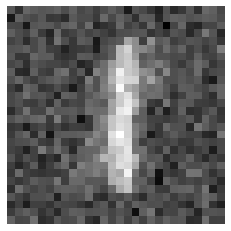

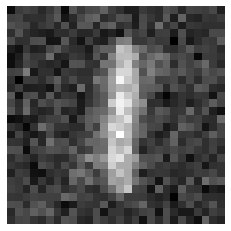

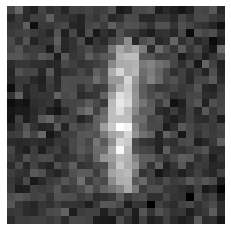

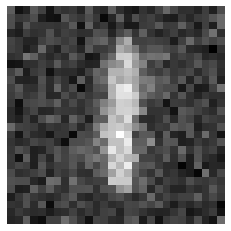

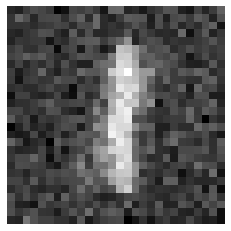

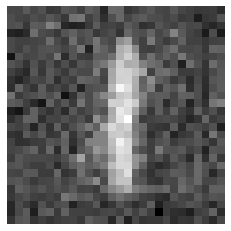

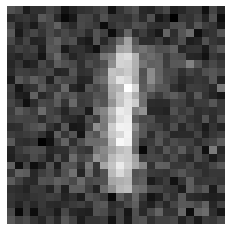

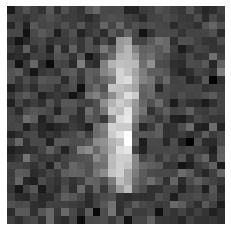

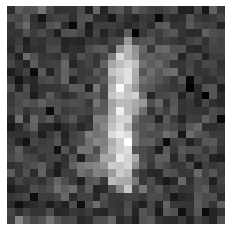

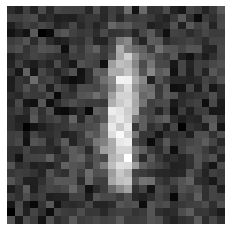

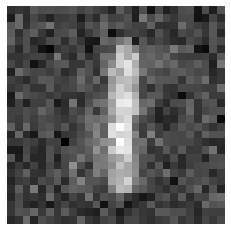

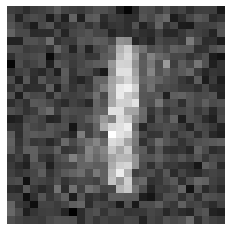

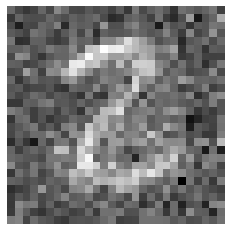

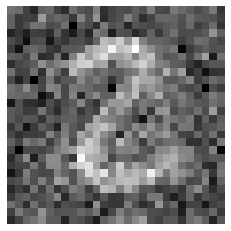

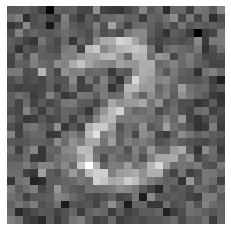

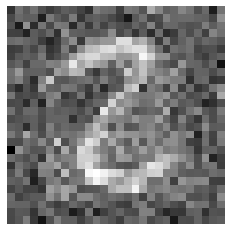

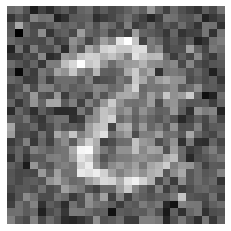

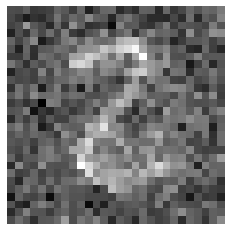

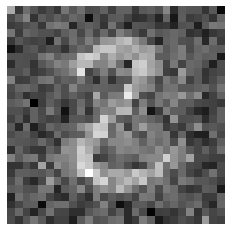

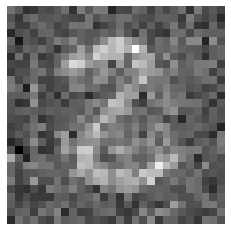

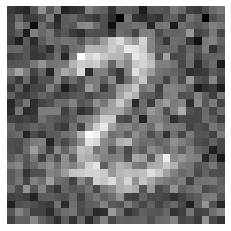

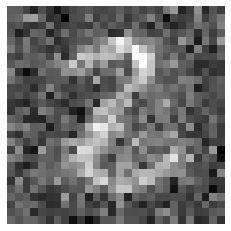

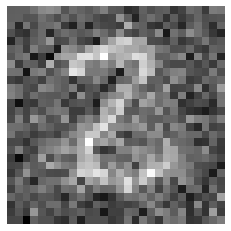

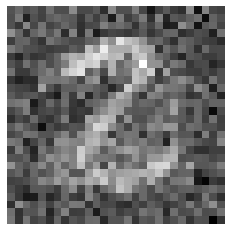

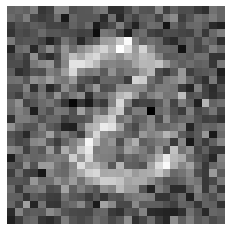

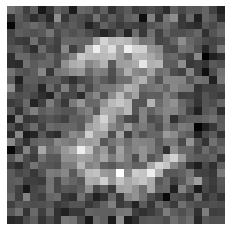

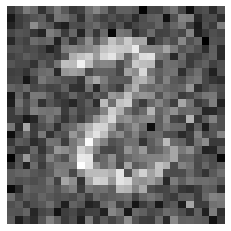

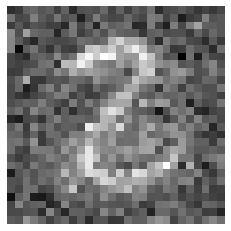

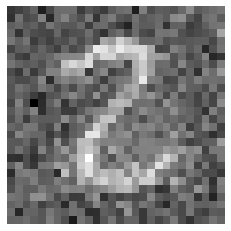

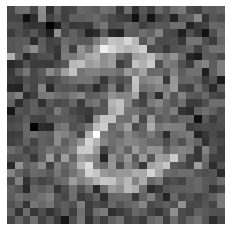

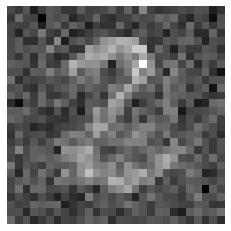

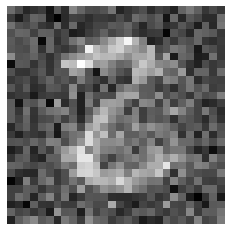

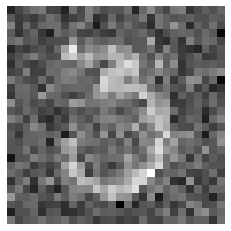

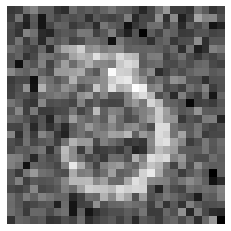

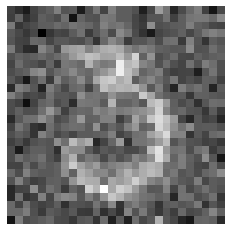

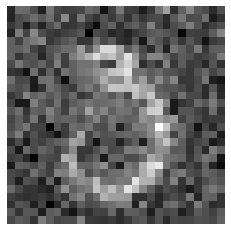

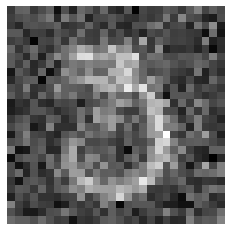

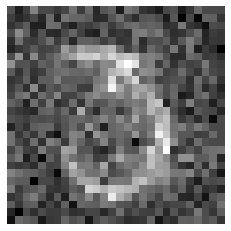

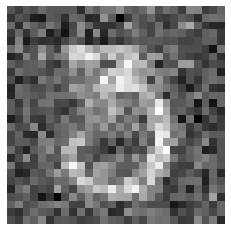

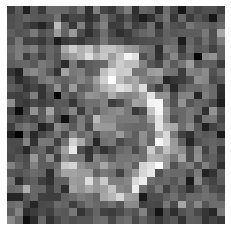

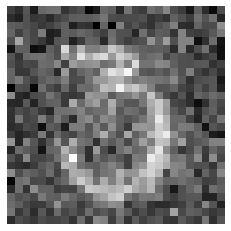

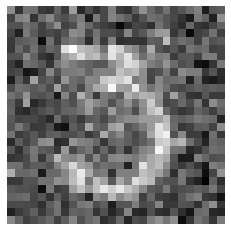

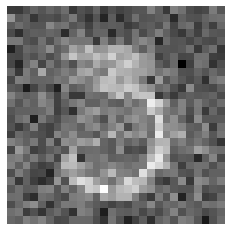

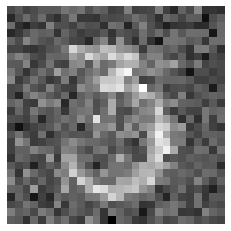

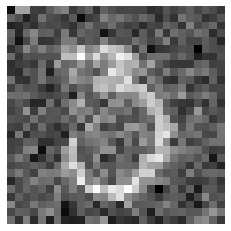

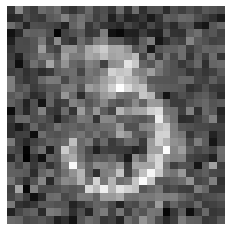

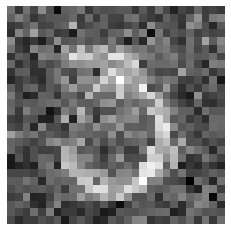

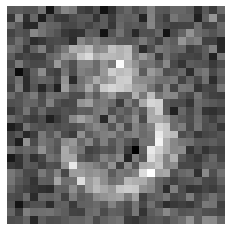

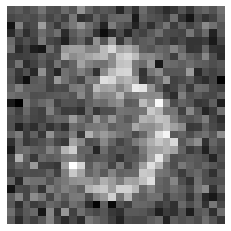

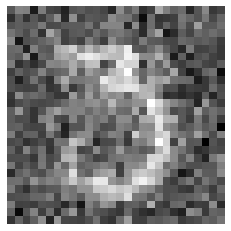

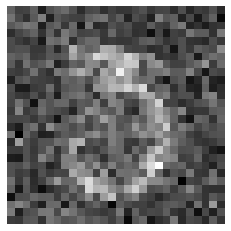

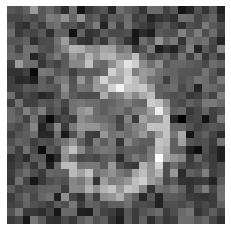

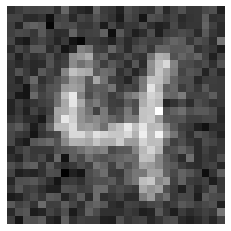

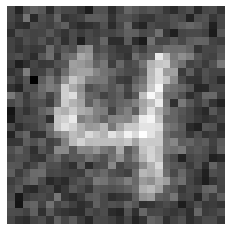

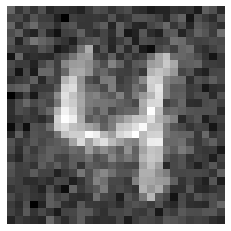

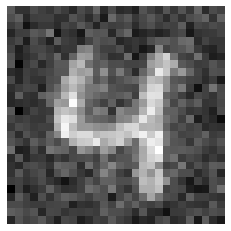

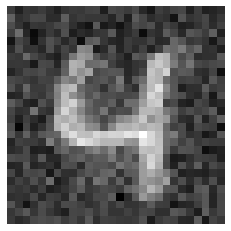

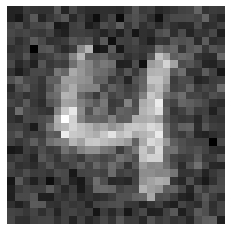

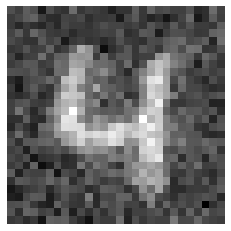

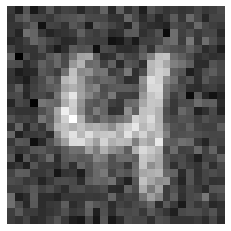

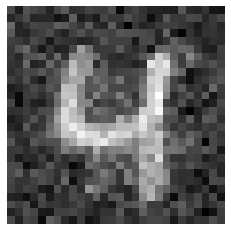

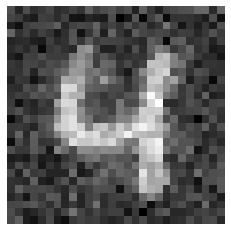

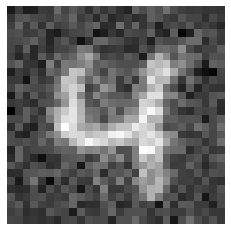

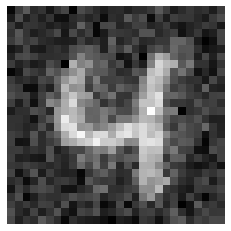

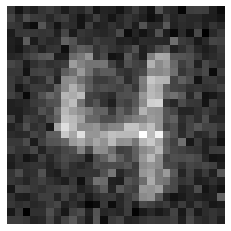

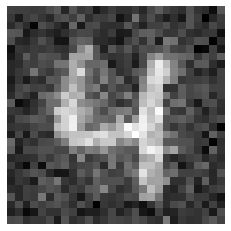

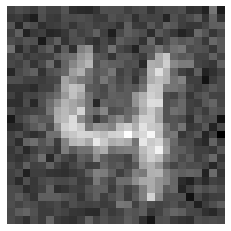

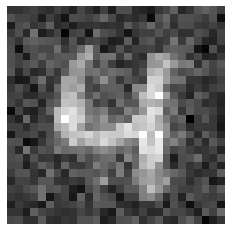

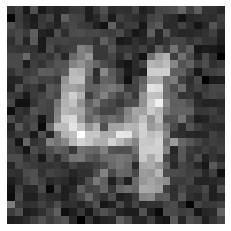

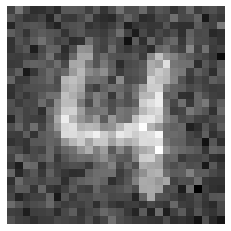

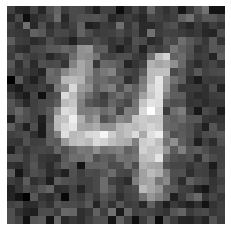

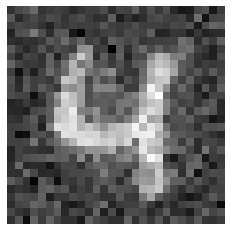

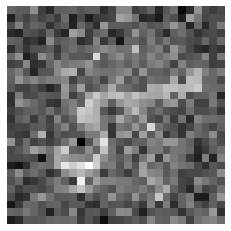

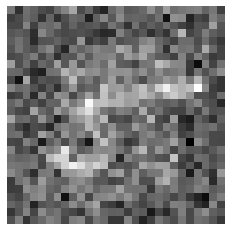

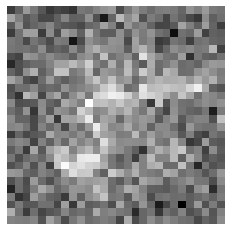

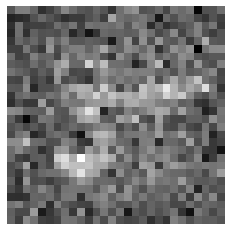

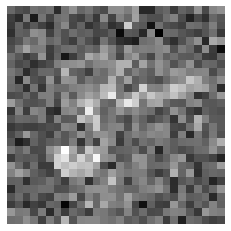

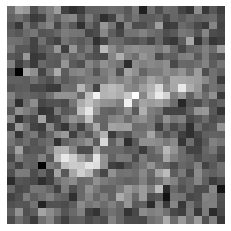

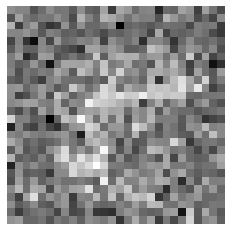

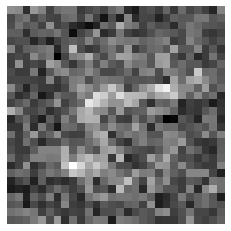

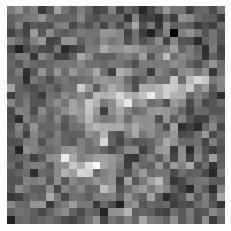

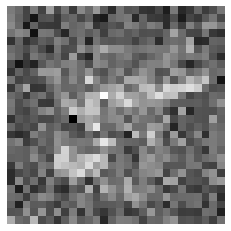

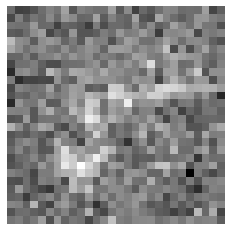

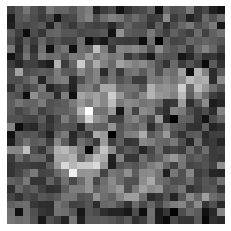

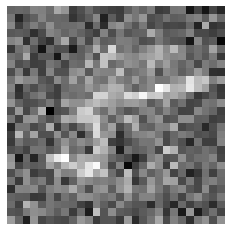

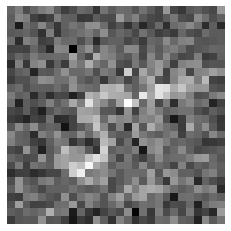

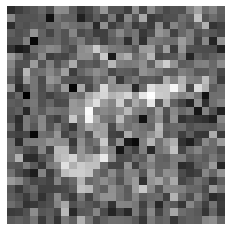

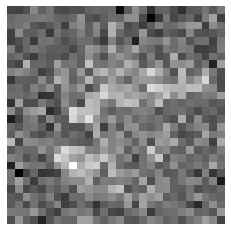

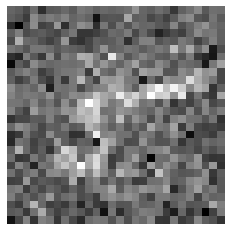

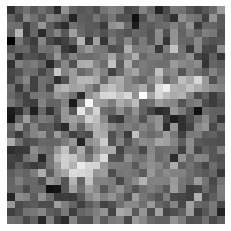

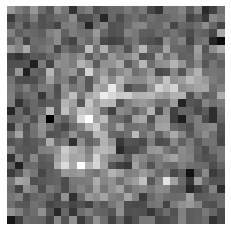

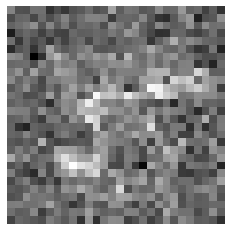

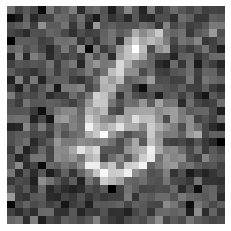

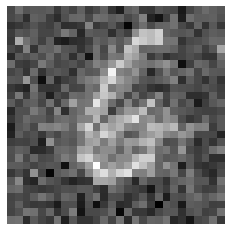

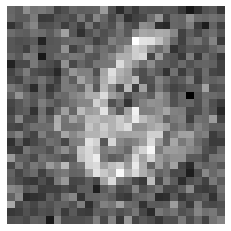

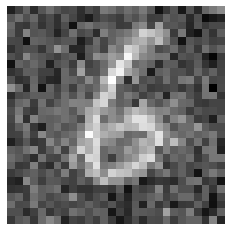

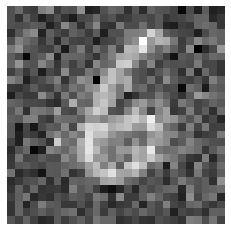

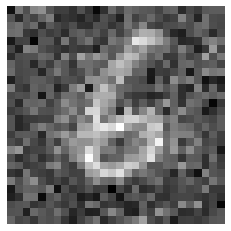

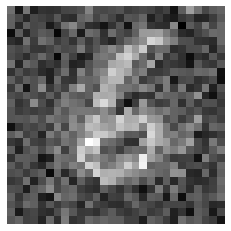

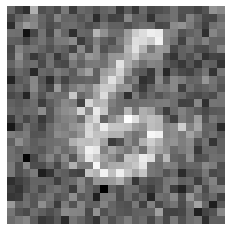

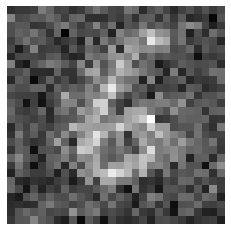

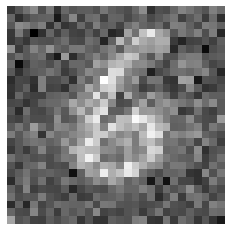

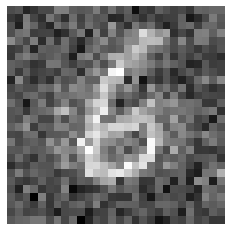

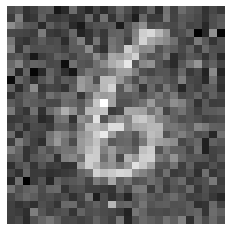

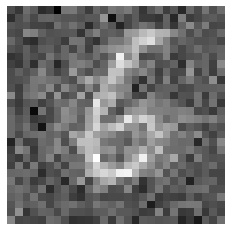

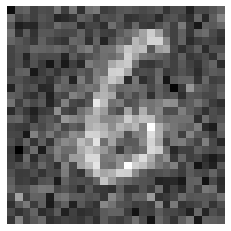

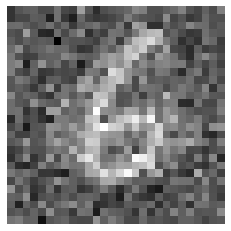

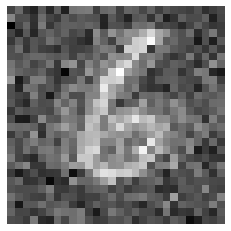

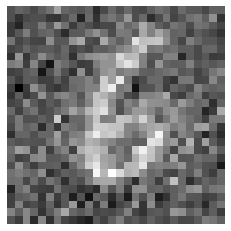

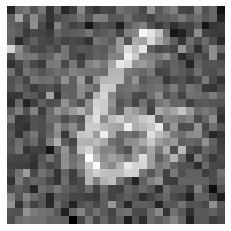

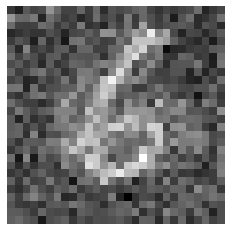

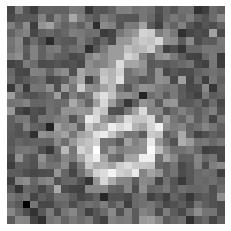

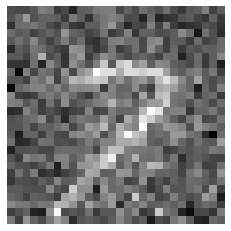

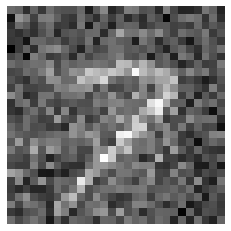

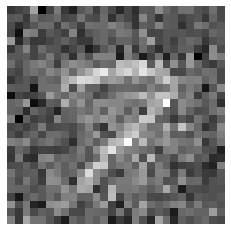

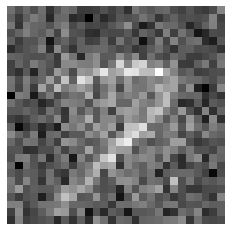

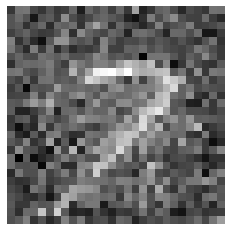

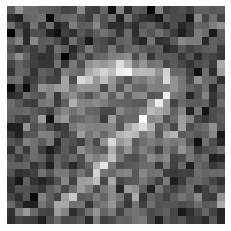

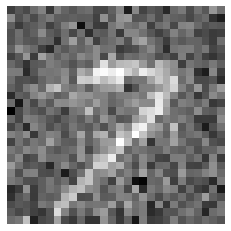

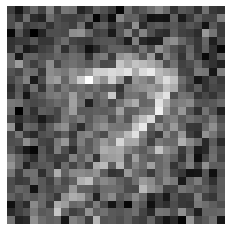

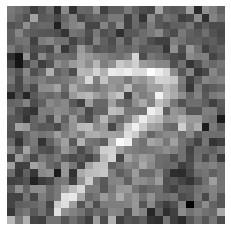

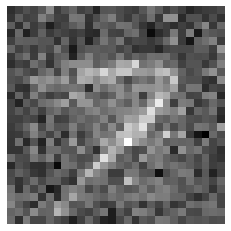

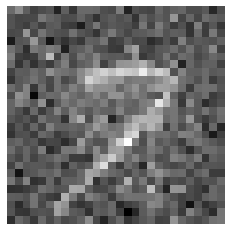

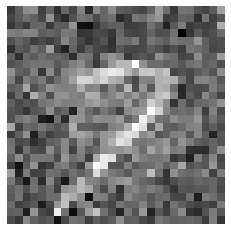

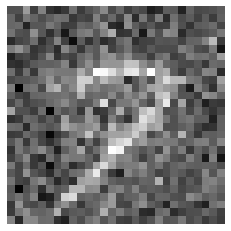

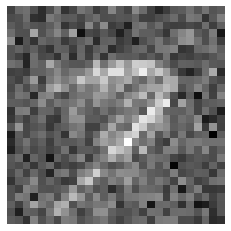

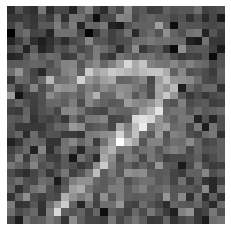

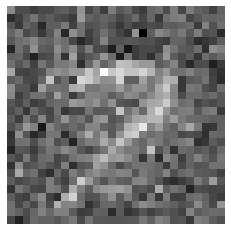

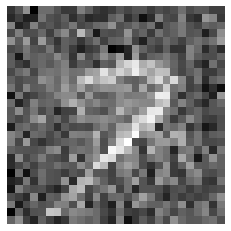

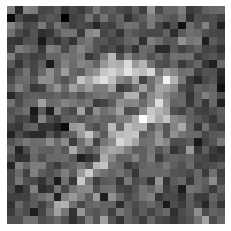

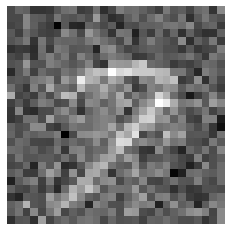

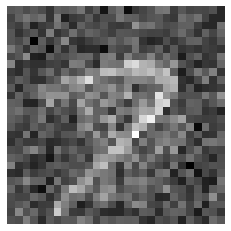

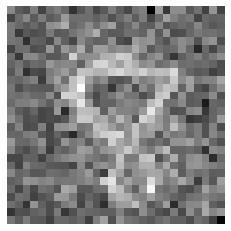

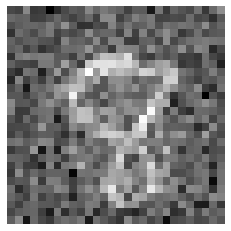

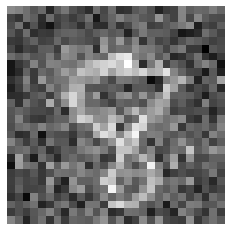

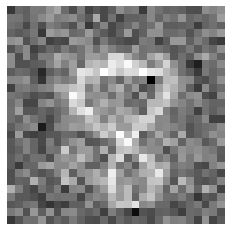

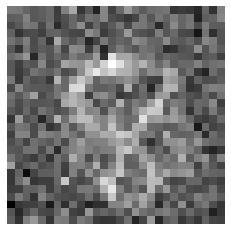

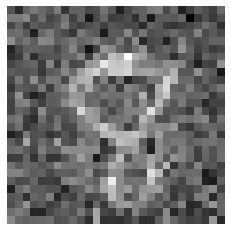

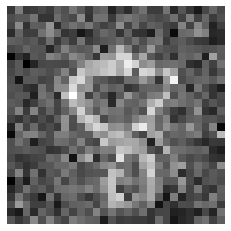

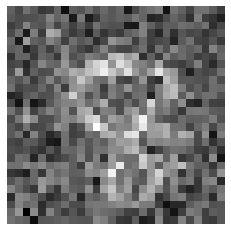

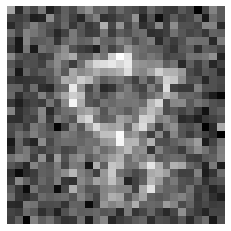

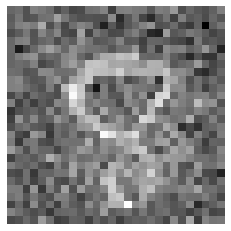

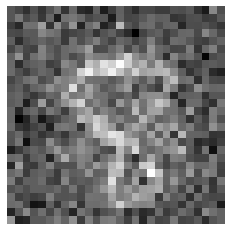

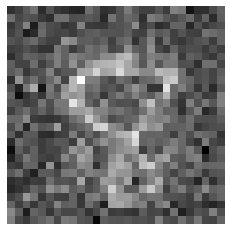

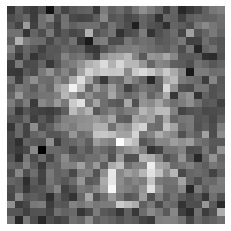

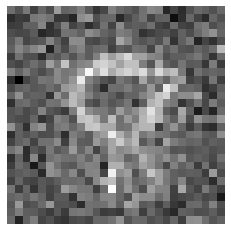

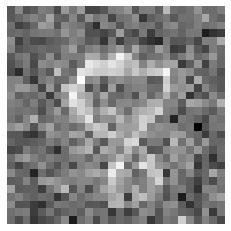

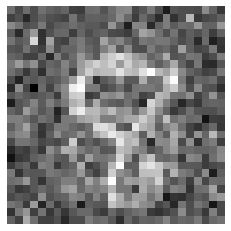

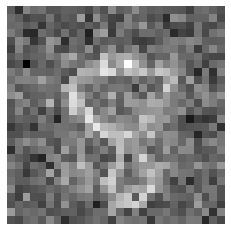

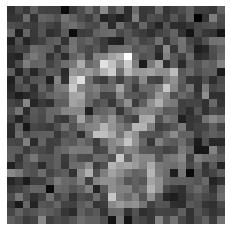

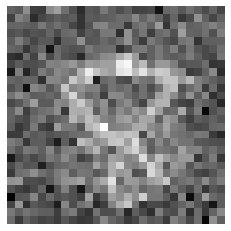

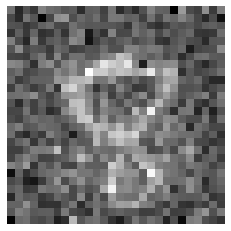

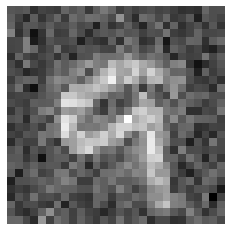

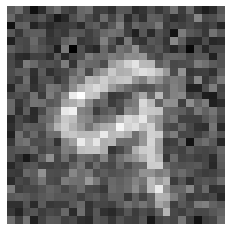

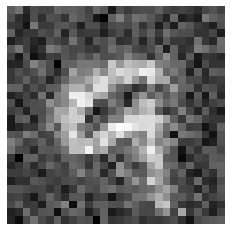

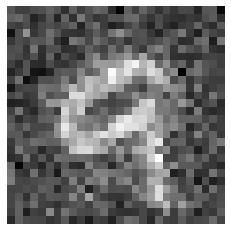

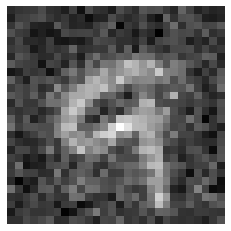

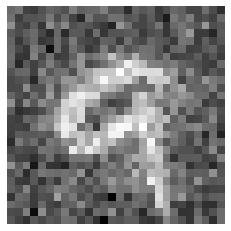

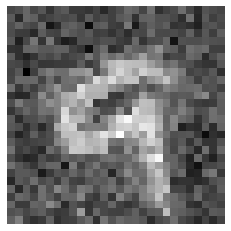

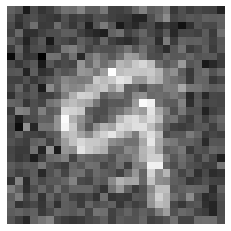

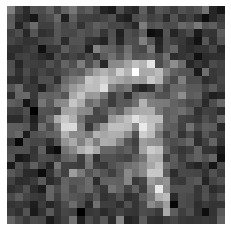

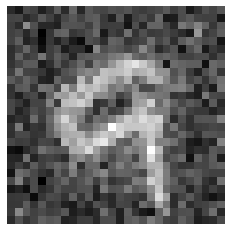

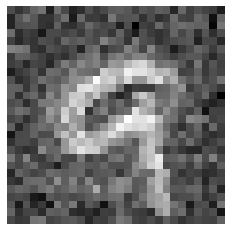

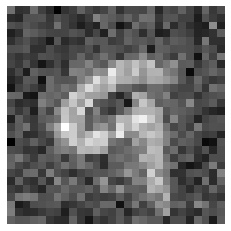

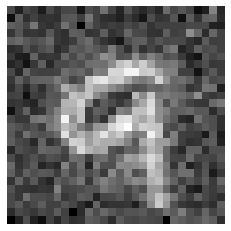

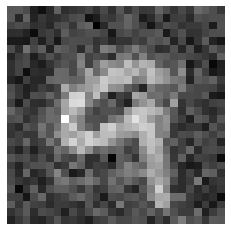

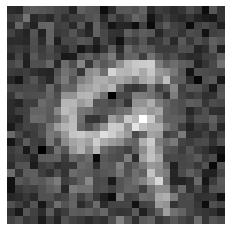

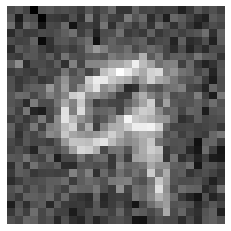

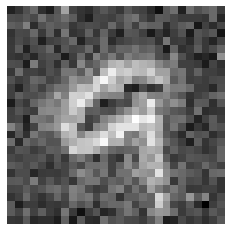

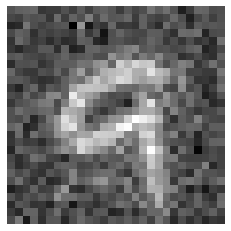

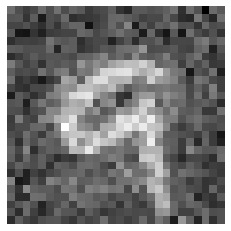

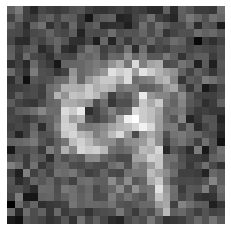

In [34]:
for lbl in range(10):
    generated_data = model.generate(20, str(lbl))
    for i in range(20):
        draw_mnist(generated_data[i])

In [45]:
x1 = model.encoder.h
x2 = model.model
eps = 1e-8

In [105]:
x1

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1533, -0.1636, -0.1718,  ..., -0.0911, -0.1400, -0.3235],
        [-0.0859, -0.1310, -0.3237,  ..., -0.1402, -0.2353, -0.4564],
        ...,
        [-0.2037, -0.1640, -0.3717,  ..., -0.1709, -0.2285, -0.5206],
        [-0.0340, -0.1543, -0.2124,  ..., -0.0771, -0.0848, -0.2666],
        [ 0.1437,  0.0951, -0.1373,  ...,  0.1043, -0.0012, -0.1273]])

In [106]:
x2

tensor([[  6.4186,  14.0111, -19.4164,  ...,  -5.7692,  -2.1359, -21.2990],
        [ -3.4174,  23.6220, -26.1093,  ...,   8.5017,  -4.9610, -36.2761],
        [ 21.3240,  20.1103, -40.2016,  ...,   3.1890, -21.0361, -45.7815],
        ...,
        [ 41.2169,  26.6967, -74.4184,  ...,  14.6463,  11.6268, -64.1353],
        [ 13.2836,  17.6471, -34.9026,  ...,  11.5990,  -2.8741, -43.7845],
        [ 34.1583,  29.1562, -66.3095,  ...,  21.3338,   7.4523, -69.2613]])

In [47]:
eps = torch.tensor(eps)

In [92]:
norms1 = x1.norm(dim=1).unsqueeze(1).max(eps) # 유클리드 규범

norms1, norms1.shape

(tensor([[1.0000e-08],
         [1.9717e+01],
         [2.5024e+01],
         ...,
         [3.0444e+01],
         [1.8148e+01],
         [1.6976e+01]]),
 torch.Size([52501, 1]))

In [93]:
norms2 = x2.norm(dim=1).unsqueeze(0).max(eps)
norms2, norms2.shape

(tensor([[2521.8674, 2383.1892, 4535.2422, 5572.0889, 6945.1401, 6888.6606,
          6001.4292, 6807.8345, 3057.9385, 6152.0640]]),
 torch.Size([1, 10]))

In [94]:
cdist = x1 @ x2.T
cdist, cdist.shape

(tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
               0.0000,      0.0000],
         [ 36775.2266,  24574.2559,  67551.2812,  ...,  96356.6641,
           44659.5938,  91158.0078],
         [ 36778.9805,  21703.3242,  68058.0000,  ..., 104571.6328,
           45433.1797,  92697.4141],
         ...,
         [ 37632.2109,  21498.5195,  67166.6484,  ..., 100249.0078,
           46047.7148,  92204.5938],
         [ 36683.4727,  28142.1855,  72440.4688,  ..., 102004.1641,
           47772.8711,  95386.1484],
         [ 35626.0352,  25937.4258,  68083.7109,  ..., 104794.2031,
           47507.4453,  98224.4062]]),
 torch.Size([52501, 10]))

In [100]:
dist = cdist.div(norms1).div(norms2)
dist, dist.shape

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.7396, 0.5230, 0.7554,  ..., 0.7179, 0.7407, 0.7515],
         [0.5828, 0.3639, 0.5997,  ..., 0.6138, 0.5937, 0.6021],
         ...,
         [0.4902, 0.2963, 0.4865,  ..., 0.4837, 0.4946, 0.4923],
         [0.8015, 0.6507, 0.8801,  ..., 0.8256, 0.8608, 0.8543],
         [0.8321, 0.6411, 0.8843,  ..., 0.9067, 0.9151, 0.9405]]),
 torch.Size([52501, 10]))

In [102]:
dist.argmax(1)

tensor([0, 6, 7,  ..., 5, 2, 9])

In [103]:
dist.argmax(1).shape

torch.Size([52501])

In [108]:
x2.shape

torch.Size([10, 10000])

In [112]:
tmp = model.encoder.h

tmp = tmp[1:]
tmp.shape

torch.Size([52500, 10000])

In [171]:
tmp

tensor([[-0.1533, -0.1636, -0.1718,  ..., -0.0911, -0.1400, -0.3235],
        [-0.0859, -0.1310, -0.3237,  ..., -0.1402, -0.2353, -0.4564],
        [ 0.3681,  0.4995,  0.1957,  ...,  0.3242,  0.3290,  0.1743],
        ...,
        [-0.2037, -0.1640, -0.3717,  ..., -0.1709, -0.2285, -0.5206],
        [-0.0340, -0.1543, -0.2124,  ..., -0.0771, -0.0848, -0.2666],
        [ 0.1437,  0.0951, -0.1373,  ...,  0.1043, -0.0012, -0.1273]])

In [114]:
y

tensor([3, 7, 1,  ..., 5, 2, 9])

In [138]:
dic = {"1":torch.empty(2, 10000),
       "2":torch.empty(2, 10000),
       "3":torch.empty(2, 10000),
       "4":torch.empty(2, 10000),
       "5":torch.empty(2, 10000),
       "6":torch.empty(2, 10000),
       "7":torch.empty(2, 10000),
       "8":torch.empty(2, 10000),
       "9":torch.empty(2, 10000)  }

In [160]:
# 최소
data = tmp[0]
dic_min = dic[str(y[0].item())][0] 

result1 = torch.tensor([data[i] if data[i] < dic_min[i] else dic_min[i] for i in range(10000)])

In [172]:
# 최대
dic_max = dic[str(y[0].item())][1]

result2 = torch.tensor([data[i] if data[i] > dic_min[i] else dic_min[i] for i in range(10000)])

In [173]:
dic["1"] = torch.stack((result1, result2), 0)

In [184]:
data

tensor([-0.1533, -0.1636, -0.1718,  ..., -0.0911, -0.1400, -0.3235])

In [183]:
dic["1"]

tensor([[-0.1533, -0.1636, -0.1718,  ..., -0.0911, -0.1400, -0.3235],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [182]:
torch.randn(10000, 784)

tensor([[ 1.3924, -0.5038,  0.3693,  ..., -0.0544, -1.0788,  0.5368],
        [ 0.6929,  1.3094, -0.2801,  ..., -1.2400,  0.8316, -0.5727],
        [ 0.0551,  0.4833,  0.2084,  ...,  0.1866,  1.2781, -0.7217],
        ...,
        [ 0.5425, -2.2821, -0.8554,  ..., -0.4495,  0.0698, -0.9413],
        [ 0.1581,  0.1784, -0.1156,  ..., -0.5018,  0.2426,  1.2654],
        [-1.3688, -1.9552, -0.9033,  ..., -0.0473,  0.2141,  0.4648]])

In [195]:
a = torch.rand((20, 10000))
a

tensor([[0.3057, 0.6364, 0.7454,  ..., 0.1018, 0.4370, 0.5340],
        [0.1126, 0.3196, 0.2621,  ..., 0.8273, 0.0462, 0.4349],
        [0.6988, 0.9374, 0.8624,  ..., 0.6433, 0.8933, 0.4397],
        ...,
        [0.7336, 0.3174, 0.9374,  ..., 0.1612, 0.6877, 0.1464],
        [0.0339, 0.7162, 0.1071,  ..., 0.3437, 0.6072, 0.7424],
        [0.5352, 0.0783, 0.2362,  ..., 0.1104, 0.5279, 0.9864]])

In [196]:
b = torch.rand((20, 10000))
b

tensor([[0.1404, 0.9747, 0.1875,  ..., 0.5552, 0.8455, 0.5314],
        [0.1387, 0.1867, 0.5441,  ..., 0.8210, 0.8259, 0.0435],
        [0.7069, 0.2812, 0.3464,  ..., 0.0590, 0.2355, 0.4553],
        ...,
        [0.3269, 0.3868, 0.5483,  ..., 0.9848, 0.1671, 0.8779],
        [0.5659, 0.8001, 0.1170,  ..., 0.4039, 0.9778, 0.7676],
        [0.1021, 0.9249, 0.1969,  ..., 0.3899, 0.7849, 0.5276]])

In [198]:
((b - a) * 0.5 ) + a

tensor([[0.2230, 0.8056, 0.4665,  ..., 0.3285, 0.6412, 0.5327],
        [0.1256, 0.2531, 0.4031,  ..., 0.8241, 0.4361, 0.2392],
        [0.7029, 0.6093, 0.6044,  ..., 0.3512, 0.5644, 0.4475],
        ...,
        [0.5303, 0.3521, 0.7428,  ..., 0.5730, 0.4274, 0.5122],
        [0.2999, 0.7581, 0.1120,  ..., 0.3738, 0.7925, 0.7550],
        [0.3187, 0.5016, 0.2165,  ..., 0.2501, 0.6564, 0.7570]])

In [205]:
c = torch.rand((20, 10000))
c

tensor([[0.1949, 0.9348, 0.1910,  ..., 0.8753, 0.7417, 0.3695],
        [0.5301, 0.0367, 0.9781,  ..., 0.4120, 0.1816, 0.6635],
        [0.4627, 0.9406, 0.2451,  ..., 0.6725, 0.3158, 0.8660],
        ...,
        [0.9456, 0.1002, 0.9285,  ..., 0.4125, 0.7894, 0.4063],
        [0.8502, 0.2980, 0.8456,  ..., 0.4730, 0.9276, 0.5619],
        [0.9120, 0.1746, 0.4188,  ..., 0.8877, 0.6723, 0.2394]])

In [206]:
(b - a) * c

tensor([[-0.0322,  0.3162, -0.1065,  ...,  0.3969,  0.3030, -0.0010],
        [ 0.0138, -0.0049,  0.2759,  ..., -0.0026,  0.1416, -0.2597],
        [ 0.0037, -0.6173, -0.1264,  ..., -0.3929, -0.2077,  0.0135],
        ...,
        [-0.3846,  0.0070, -0.3612,  ...,  0.3398, -0.4110,  0.2972],
        [ 0.4524,  0.0250,  0.0083,  ...,  0.0285,  0.3437,  0.0142],
        [-0.3950,  0.1478, -0.0164,  ...,  0.2481,  0.1728, -0.1098]])

In [207]:
(0.1404 - 0.3057)*0.1949

-0.032216970000000004

In [209]:
model.encoder.h

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1533, -0.1636, -0.1718,  ..., -0.0911, -0.1400, -0.3235],
        [-0.0859, -0.1310, -0.3237,  ..., -0.1402, -0.2353, -0.4564],
        ...,
        [-0.2037, -0.1640, -0.3717,  ..., -0.1709, -0.2285, -0.5206],
        [-0.0340, -0.1543, -0.2124,  ..., -0.0771, -0.0848, -0.2666],
        [ 0.1437,  0.0951, -0.1373,  ...,  0.1043, -0.0012, -0.1273]])